In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
# using Path to handle switches filesystems
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

vol_file = Path('analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

## This analysis tries to reproduce TK's calcium results

In [43]:
from utils import *

### Find example neurons

n_fish: 0
11


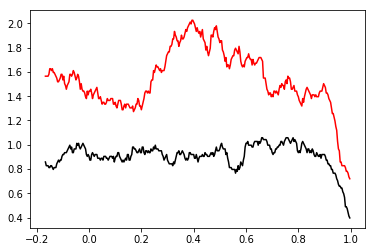

n_fish: 1
19


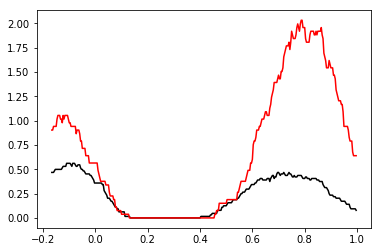

n_fish: 2
n_fish: 3
12


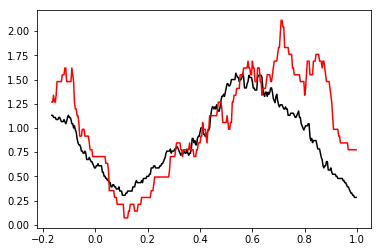

n_fish: 4
n_fish: 5
4


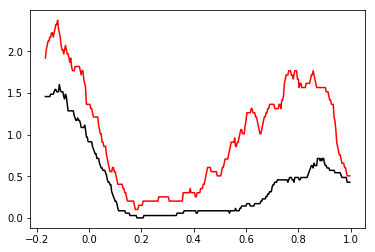

14


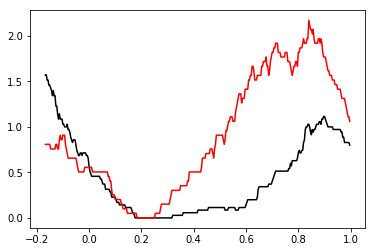

n_fish: 6
8


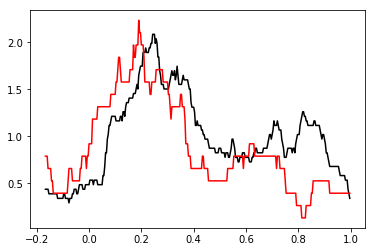

9


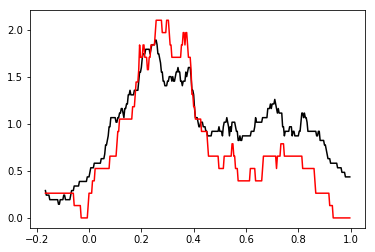

11


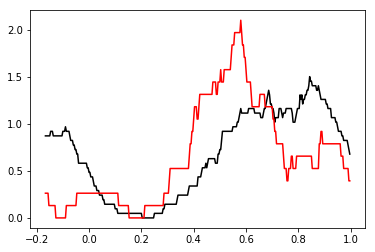

n_fish: 7
n_fish: 8
n_fish: 9
n_fish: 10
n_fish: 11
n_fish: 12
n_fish: 13
n_fish: 14
3


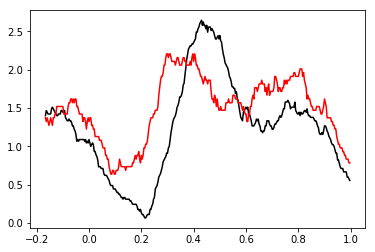

17


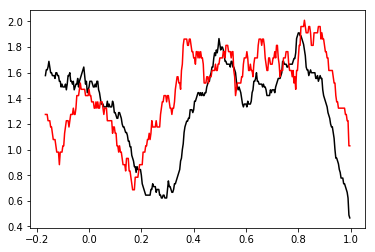

n_fish: 15
n_fish: 16
1


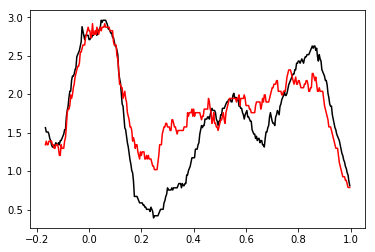

6


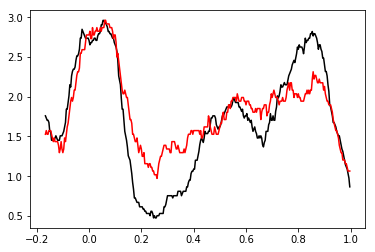

n_fish: 17
20


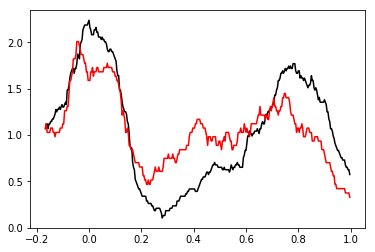

22


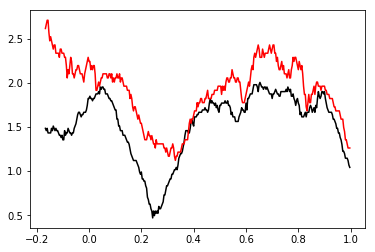

In [140]:
k_ = boxcarKernel(sigma=60)
spk_cell_list = []
n_row = -1
for _, row in dat_xls_file.iterrows():
    n_row+=1
    folder = row['folder']
    fish = row['fish']
    if 'memory' not in row['task']:
        continue
    print(f'n_fish: {n_row}')
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    # spk with padding zeros for the first 2 seconds
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    time_end = 350
    
    for n_cell in range(spk.shape[0]):
        spk_list = np.zeros((r_swim.shape[0], 400))
        remove_list = np.zeros(r_swim.shape[0]).astype('bool')
        for n, n_swim in enumerate(swim_starts):
            try:
                spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300]
            except:
                remove_list[n]=True
        spk_list = spk_list[~remove_list, :]
        
        ave_ = spk_list[task_period[~remove_list]==1, :].mean(axis=0)*300
        ave_low = smooth(ave_, k_)
        ave_ = spk_list[task_period[~remove_list]==2, :].mean(axis=0)*300
        ave_high = smooth(ave_, k_)

        diff_ = (ave_high - ave_low).max()
        spk_cell_list.append(diff_)
    
        if ave_high.max()>2:
            print(n_cell)
#             plt.plot(np.arange(time_end)/300-50/300, ave_low[50:time_end+50], '-k')
#             plt.plot(np.arange(time_end)/300-50/300, ave_high[50:time_end+50], '-r')
#             plt.show()

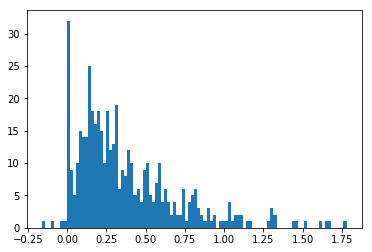

In [111]:
plt.hist(spk_cell_list, bins=100)
plt.show()

### plot example neurons

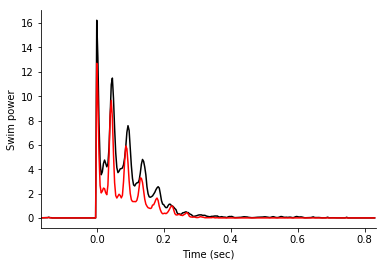

In [208]:
nfish = 1
ncell_ = 11
row = dat_xls_file.iloc[nfish]
folder = row['folder']
fish = row['fish']
# print(f'Processing {folder} {fish}')
dat_dir = dir_folder/f'{folder}/{fish}/Data/'
swim_dir = dir_folder/f'{folder}/{fish}/swim/'
dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
num_cell = spk.shape[0]
# spk with padding zeros for the first 2 seconds
spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

_ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
swim_starts = _['swim_starts']
swim_ends = _['swim_ends']
r_swim = _['r_swim']
l_swim = _['l_swim']
visu = _['visu']
task_period = _['task_period']
swim_task_index = _['swim_task_index']

p_swim = np.sqrt(r_swim**2+l_swim**2)

plt.plot(np.arange(300)/300-50/300, p_swim[task_period==1, :].mean(axis=0), '-k')
plt.plot(np.arange(300)/300-50/300, p_swim[task_period==2, :].mean(axis=0), '-r')
plt.ylabel('Swim power')
plt.xlabel('Time (sec)')
plt.xlim([-50/300, 250/300])
# plt.ylim([0, 160])
# plt.vlines([0], [0], [320], colors='k', linestyles='--')
sns.despine()
plt.show()

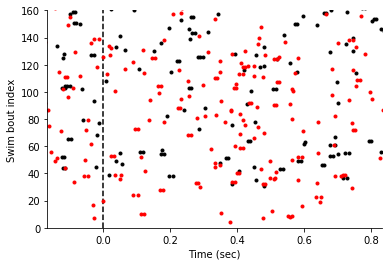

In [209]:
spk_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300] 
        except:
            pass
    plt_raster(spk_list[task_period==1, :], c='k')
    plt_raster(spk_list[task_period==2, :], c='r')
    # plt.title(f'Cell #{n_cell}')
    plt.ylabel('Swim bout index')
    plt.xlabel('Time (sec)')
    plt.xlim([-50/300, 250/300])
    plt.ylim([0, 160])
    plt.vlines([0], [0], [320], colors='k', linestyles='--')
    sns.despine()
    plt.show()

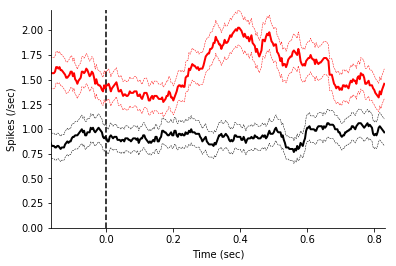

In [210]:
# k_ = gaussKernel(sigma=20)
k_ = boxcarKernel(sigma=60)
# ave_ = spk_list[task_period==1, :].mean(axis=0)*300
ave_ = []
for n_spk in spk_list[task_period==1, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-k', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--k', lw=0.5)


ave_ = []
for n_spk in spk_list[task_period==2, :]*300:
    ave_.append(smooth(n_spk, k_))
ave_ = np.array(ave_)
mean_ = ave_[:, 50:350].mean(axis=0)
std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(300)/300-50/300, mean_, '-r', lw=2)
plt.plot(np.arange(300)/300-50/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(300)/300-50/300, mean_+std_, '--r', lw=0.5)

plt.ylim([0, 2.2])
plt.xlim([-50/300, 250/300])
plt.vlines([0], [0], [2.2], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()

In [211]:
from scipy.signal import medfilt

subvolt = dff.copy()
for n, ndff in enumerate(dff):
    subvolt[n, :] = medfilt(ndff, kernel_size=51)

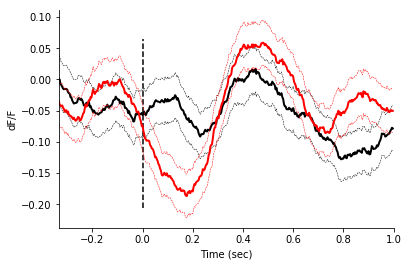

In [215]:
sub_list = np.zeros((r_swim.shape[0], 400))
for n_cell in range(spk_list.shape[0]):
    if n_cell != ncell_:
        continue
    for n, n_swim in enumerate(swim_starts):
        try:
            sub_list[n, :] = subvolt[n_cell, n_swim-100:n_swim+300] 
        except:
            pass

t_min = 0
t_max = 400
ave_ = sub_list[task_period==1, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[:(100-t_min)].max()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-k', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--k', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--k', lw=0.5)

ave_ = sub_list[task_period==2, :]*100
mean_ = ave_[:, t_min:t_max].mean(axis=0)
mean_ = mean_ - mean_[:(100-t_min)].max()
max_ = mean_.max()
min_ = mean_.min()
std_ = ave_[:, t_min:t_max].std(axis=0)/np.sqrt(ave_.shape[0])
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-r', lw=2)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--r', lw=0.5)
plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--r', lw=0.5)

# plt.ylim([0, 2.2])
plt.xlim([-(100-t_min)/300, (t_max-100)/300])
plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
plt.xlabel('Time (sec)')
plt.ylabel('dF/F')
sns.despine()

In [ ]:


swim_starts = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==1)[0]
swim_ends   = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==-1)[0]
swim_ends   = swim_ends[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
swim_starts = swim_starts[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
task_period = frame_stimParams[2,swim_starts]
task_index  = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;
swim_task_index = task_index[swim_starts]
swim_count  = np.zeros((len(swim_starts),))